# 2022-0X-XX_001__NAME

You can put description, notes, anything.
Running single cell: Ctrl+Enter

# Scripts & data

In [79]:
isHot = True
isSaving = isHot and True
datadir = 'data'
figsdir = 'figs'

# Native libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
from time import sleep
from datetime import datetime
from time import sleep
from tqdm import tqdm
import lzma
import warnings
import os
datadir_full = os.path.join(os.getcwd(),datadir)
import sys
sys.path.insert(0,'C:/git/py_libs_LabControl') #Lab PC
sys.path.insert(0,'D:/Repositories/py_libs_LabControl') #XMG
from IPython.display import Markdown #for text coloring

# Instrument libraries
try:
    from RsInstrument import BinFloatFormat
    import RsInstrument as rs
    import pyvisa as visa
    import pyarbtools
    display (Markdown('<span style="color: #1fa774">All instrument control packages found and loaded.</span>'))
except:
    display (Markdown('<span style="color: #e17701;font-weight:bold">At least one of the instrument library failed to load. Remote control of lab equipment is not operational.</span>'))

# Custom libraries
import LabControlToolkit as lab
from LabControlToolkit import find_nearest

# Initiate remote control for lab instruments
awg = None
rth = None
sm = None

if isHot:
    try:
        awg = pyarbtools.instruments.M8190A('130.159.91.79', port=5025, timeout=30, reset=False)
    except:
        awg = pyarbtools.instruments.M8190A('127.0.0.1', port=5025, timeout=30, reset=False)
    
    try:
        rth = lab.Initiate_OSC()
    except:
        warnings.warn('Oscilloscope not connected.',RuntimeWarning)
        
    try:
        sm = lab.Initiate_Keithley()
        sm.measure_current(current=0.02, auto_range=True)
        sm.apply_voltage(voltage_range=2, compliance_current=0.02)    
    except:
        display (Markdown('<span style="color: #e17701">Keithley SM not loaded.</span>')) 
        
else:
    awg = lab.Mock()
    rth = lab.Mock()
    sm = lab.Mock()
#%%

<span style="color: #1fa774">All instrument control packages found and loaded.</span>

Connected to oscilloscope.
Device IDN: Rohde&Schwarz,RTP,1320.5007k08/100963,4.80.1.0
Device Options: K37,B1,B4,B10,B102,B0816



<span style="color: #e17701">Keithley SM not loaded.</span>

## AWG Waveforms

<span style="color: #1fa774">Used AWG channels: </span> <span style="color:#1fa774; font-weight:bold">(1, 2)</span>.

Waveform WF1 length (samples): 3590
Waveform WF2 length (samples): 400140
Waveform WF1 length after rounding (samples): 3000
Waveform WF2 length after rounding (samples): 3000


<span style="color: #e17701;font-weight:bold">Waveform displayed, but not sent to instrument. Reason: [isHot = False].</span>

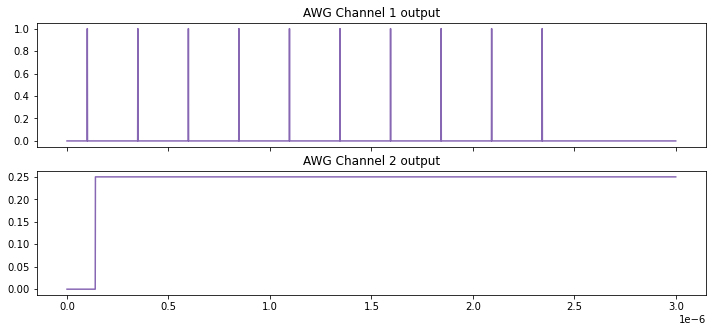

In [75]:
samplerate = 1e9
using_AWG_channels = (1,2) # Denominate used channels: (1,),(2,),(1,2)
wf_rounding_factor = 1000 # Rounds waveform length to (ideally) avoid high repetitions during AWG synthesis

#### IMPORTANT!!!!: Sets voltage for AWG outputs
ch1_voltage = 0.2
ch2_voltage = 0.1

# Note: variables that contain 'ch1_' or 'ch2_' are auto-saved with each measurement
# Therefore, if you want any mod parameters to be saved, make sure their name includes channel reference

################################
display (Markdown('<span style="color: #1fa774">Used AWG channels: </span> <span style="color:#1fa774; font-weight:bold">'+str(using_AWG_channels)+'</span>.'))
# CHANNEL 1
if 1 in using_AWG_channels:
    ##### CHANGE WF FROM HERE
    ch1_pulse_length_sa = 1
    ch1_trigseparation = 250e-9
    ch1_wf1amp = 1
    ch1_pulse_count = 10
    ch1_separator = 1000e-9
    ch1_offset_A = 0
    
    wf1_y = np.zeros(100+int(ch1_offset_A*samplerate))

    for ii in range(ch1_pulse_count):
        sep = ch1_trigseparation-(ch1_pulse_length_sa/samplerate)
        wf1_y = np.concatenate((wf1_y,
                              np.ones(int(ch1_pulse_length_sa))*ch1_wf1amp,
                              np.zeros(int(sep*samplerate))))

    wf1_y = np.concatenate((wf1_y,np.zeros(int(ch1_separator*samplerate)))) 
    
    ##### CHANGE WF TO HERE
    wf1len = wf1_y.shape[0]
    print(f'Waveform WF1 length (samples): {wf1_y.shape[0]}')
    
################################
# CHANNEL 2
if 2 in using_AWG_channels:
    ch2_step_len = 1/10e3
    ch2_levels = (0.25,0.5,0.75,1)
    ch2_wf2amp = 1
    
    offset_B = 40e-9
    zerolvl = 0

    wf2_y = np.ones(100+int(offset_B*samplerate))*zerolvl
    for level in ch2_levels:
        wf2_y = np.concatenate((wf2_y,
                              np.ones(int(samplerate*ch2_step_len))*ch2_wf2amp*level#,
                              #np.ones(int(samplerate*step_len))*0
                              ))
    #### Change to here    
    wf2len = wf2_y.shape[0]    
    print(f'Waveform WF2 length (samples): {wf2_y.shape[0]}')
#wf2 = np.concatenate((wf2,np.ones(int(10*separator*samplerate))*zerolvl))    
#wf2 = wf2/np.max(wf2)

###############################

#### Disable WF2 locally:
'''
wf2 = np.zeros(wf1len)
wf2len = wf2.shape[0]     
'''   


if using_AWG_channels == (1,2):
    if (wf1len-wf1len%wf_rounding_factor) > (wf2len-wf2len%wf_rounding_factor):
        wf1_y = wf1_y[0:(wf2len-wf2len%wf_rounding_factor)]
        wf2_y = wf2_y[0:(wf2len-wf2len%wf_rounding_factor)]
    else:
        wf1_y = wf1_y[0:(wf1len-wf1len%wf_rounding_factor)]
        wf2_y = wf2_y[0:(wf1len-wf1len%wf_rounding_factor)]  
    print(f'Waveform WF1 length after rounding (samples): {wf1_y.shape[0]}')
    print(f'Waveform WF2 length after rounding (samples): {wf2_y.shape[0]}')
    
    wf1_x = np.arange(0,wf1_y.shape[0]*1/samplerate,1/samplerate)
    wf1_x = wf1_x[0:wf1_y.shape[0]] 
    
    wf2_x = np.arange(0,wf2_y.shape[0]*1/samplerate,1/samplerate)
    wf2_x = wf2_x[0:wf2_y.shape[0]]
elif using_AWG_channels[0] == 1:
    wf1_y = wf1_y[0:(wf1len-wf1len%wf_rounding_factor)]
    print(f'Waveform WF1 length after rounding (samples): {wf1_y.shape[0]}')
    
    wf1_x = np.arange(0,wf1_y.shape[0]*1/samplerate,1/samplerate)
    wf1_x = wf1_x[0:wf1_y.shape[0]]     
    
elif using_AWG_channels[0] == 2:
    wf2_y = wf2_y[0:(wf2len-wf2len%wf_rounding_factor)]
    print(f'Waveform WF2 length after rounding (samples): {wf2_y.shape[0]}')
    wf2_x = np.arange(0,wf2_y.shape[0]*1/samplerate,1/samplerate)
    wf2_x = wf2_x[0:wf2_y.shape[0]]    
    
try:
    awg.clear_all_wfm()
except:
    pass

if isHot:
    awg.configure(fs=samplerate, out1='dac', out2='dac', amp1=ch1_voltage, amp2=ch2_voltage, func1='arb')
    print(f'Sample rate is {awg.fs/1000000} MSa/sec.')

    if 1 in using_AWG_channels:
        segment1 = awg.download_wfm(wfmData=wf1_y, ch=1, name='wfm', wfmFormat='real', sampleMkr=1, sampleMkrLength=40)
        awg.play(wfmID=segment1, ch=1)
    if 2 in using_AWG_channels:
        segment2 = awg.download_wfm(wfmData=wf2_y, ch=2, name='wfm', wfmFormat='real', sampleMkr=1, sampleMkrLength=40)
        awg.play(wfmID=segment2, ch=2)
    
    if using_AWG_channels == (1,2):
        fig,ax=plt.subplots(2,1,figsize=(12,5),sharex=True)

        ax[0].plot(wf1_x,wf1_y,color='xkcd:indigo',alpha=0.6)
        ax[0].set_facecolor((1.0, 0.47, 0.42,0.2))
        ax[0].set_title('AWG Channel 1 output')    

        ax[1].plot(wf2_x,wf2_y,color='xkcd:indigo',alpha=0.6) 
        ax[1].set_title('AWG Channel 2 output')
        ax[1].set_facecolor((1.0, 0.47, 0.42,0.2))
        
    elif len(using_AWG_channels) == 1:
        fig,ax=plt.subplots(1,1,figsize=(12,3),sharex=True)
        wf_y = eval(f'wf{using_AWG_channels[0]}_y')
        wf_x = eval(f'wf{using_AWG_channels[0]}_x')
        
        ax.plot(wf_x,wf_y,color='xkcd:indigo',alpha=0.6) 
        ax.set_title(f'AWG Channel {using_AWG_channels[0]} output')
        ax.set_facecolor((1.0, 0.47, 0.42,0.2))    
        ax.set_xlabel('Time')
else:
    display (Markdown('<span style="color: #e17701;font-weight:bold">Waveform displayed, but not sent to instrument. Reason: [isHot = False].</span>'))
    if using_AWG_channels == (1,2):
        fig,ax=plt.subplots(2,1,figsize=(12,5),sharex=True)

        ax[0].plot(wf1_x,wf1_y,color='xkcd:indigo',alpha=0.6)
        ax[0].set_title('AWG Channel 1 output')    

        ax[1].plot(wf2_x,wf2_y,color='xkcd:indigo',alpha=0.6) 
        ax[1].set_title('AWG Channel 2 output')
        
    elif len(using_AWG_channels) == 1:
        fig,ax=plt.subplots(1,1,figsize=(12,3),sharex=True)
        
        wf_y = eval(f'wf{using_AWG_channels[0]}_y')
        wf_x = eval(f'wf{using_AWG_channels[0]}_x')
        ax.plot(wf_x,wf_y,color='xkcd:indigo',alpha=0.6) 
        ax.set_title(f'AWG Channel {using_AWG_channels[0]} output')
        ax.set_xlabel('Time')

### Acquisition

C:\Users\Antonio\Miniconda3\envs\py37_main\lib\site-packages\ipykernel_launcher.py:31: UserWarning: File exists already! Press Enter to continue...


Proceeding with acquisiton...


<span style="color: #014d4e;font-weight:bold">Recording data into: 003_TEST.</span>

Mod parameters (CH1) saved:
[ch1_offset_A, ch1_pulse_count, ch1_pulse_length_sa, ch1_separator, ch1_trigseparation, ch1_voltage, ch1_wf1amp, ]
Mod parameters (CH2) saved:
[ch2_levels, ch2_step_len, ch2_voltage, ch2_wf2amp, ]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13it/s]


Measurement saved, time: 2022/05/03, 13:40:59
Filesize: 17.8KiB


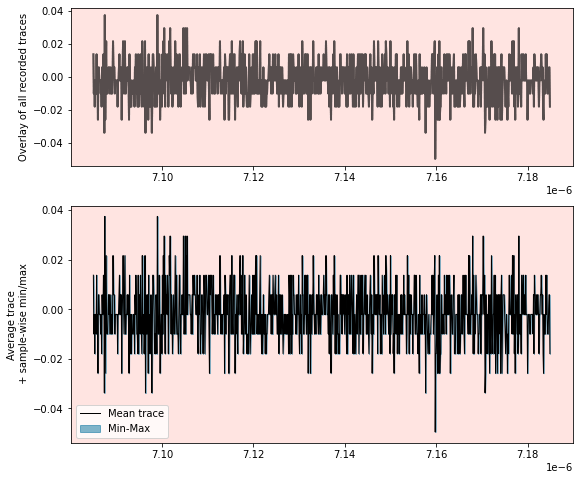

In [82]:
saved_obj = {}
#### THIS IS WHAT YOU SHOULD CHANGE ###############
fname = '003_TEST'
acq_channel = 3  # Type: 1,2,3,4 to select oscilloscope channel
repeats = 10 # How many acquisitions in sequence should be taken

saved_obj['notes_experiment'] = '''
You can save any note you want.
It can be multiple lines.
'''
#### THESE ARE SAVED PARAMETERS (USING OPTIONAL, but likely helpful)###########
saved_obj['fname'] = fname
saved_obj['repeats'] = repeats
#saved_obj['I_{vcsel}'] = 2.200e-3
#saved_obj['I_{EDFA}'] = 123e-3
#saved_obj['V_{MZM}'] = 7.67
#saved_obj['V_{SM_mas}'] = 0.830


##### HERE THE ACTUAL MEASURING STARTS, NO NEED TO CHANGE CODE BELOW ##########            
if isHot == True:
    
    #### Filename synthesis
    now = datetime.now()
    saved_obj['date'] = now.strftime("%Y/%m/%d, %H:%M:%S")
    full_fname = now.strftime("%Y-%m-%d")+'__'+fname+'.pkl.lz'
    full_filepath = os.path.join(datadir_full,full_fname)
    
    #### Overwrite check
    if os.path.isfile(full_filepath):
        warnings.warn("File exists already! Press Enter to continue...")
        entered = input()
        if entered != '':
            sys.exit()  
        print('Proceeding with acquisiton...')
    
    display (Markdown(f'<span style="color: #014d4e;font-weight:bold">Recording data into: {fname}.</span>'))
    
    #### Saving all modulation parameters via keywords search
    saved_obj['modulation'] = {}
    saved_obj['modulation']['samplerate'] = samplerate
    for jjj in using_AWG_channels:
        saved_obj['modulation'][f'wf{jjj}_x'] = eval(f'wf{jjj}_x')
        saved_obj['modulation'][f'wf{jjj}_y'] = eval(f'wf{jjj}_y')

        print(f'Mod parameters (CH{jjj}) saved:\n[',end='')
        saved_wf_par_counter = 0
        for var in dir():
            if f'ch{jjj}_' in var:
                saved_obj['modulation'][var] = eval(var)
                saved_wf_par_counter = saved_wf_par_counter+1
                print(var,end=', ')
        print(']')
     
    #### Saving Keithley voltage if available
    try:
        sm_I,sm_V = lab.Keithley_getReadout(sm)
        saved_obj['V_sm'] = sm_V
        print(f'Keithley SM voltage: {sm_V}')
    except:
        pass
    
    #### Create plots: overlay of all measurements, mean+min/max
    figR,axR = plt.subplots(2,1,figsize=(9,8),gridspec_kw={'height_ratios':(1,1.5)})
 
    #### Get readout shape to create according arrays
    t, y = lab.Acq_OSC_Trace(rth, acq_channel)
    t = t[0:len(y)]
    y = np.asarray(y)
    ytotal = np.zeros(y.shape)
    ymin = y.copy()
    ymax = y.copy()
    
    #### Measure
    pbar = tqdm(total=repeats)
    #pbar.set_description()
    for jjj in range(repeats):
        saved_obj[f'meas{jjj}'] = {}
        t, y = lab.Acq_OSC_Trace(rth, acq_channel)
        t = t[0:len(y)]
        y = np.asarray(y)
        saved_obj[f'meas{jjj}']['data_x'] = t
        saved_obj[f'meas{jjj}']['data_y'] = y
        axR[0].plot(t,y,color='xkcd:black',lw=2,alpha=1/repeats)
        ytotal = ytotal+y
        ymin = np.minimum(ymin,y)
        ymax = np.maximum(ymax,y)
        pbar.update(1)
    pbar.close()       

    #### Render mean, maximum, minimum readouts
    ytotal = ytotal/repeats     
    #axR[1].plot(t,,color='xkcd:evergreen',lw=0.5,alpha=0.5,label='Min')
    axR[1].fill_between(t,ymin,ymax,color='xkcd:ocean blue',alpha=0.5,label='Min-Max')
    axR[1].plot(t,ytotal,color='xkcd:black',lw=1,label='Mean trace')
    axR[1].legend()
    axR[0].set_facecolor((1.0, 0.47, 0.42,0.2))
    axR[1].set_facecolor((1.0, 0.47, 0.42,0.2))
    axR[0].set_ylabel('Overlay of all recorded traces')
    axR[1].set_ylabel('Average trace\n + sample-wise min/max')
    
    #### Dump mean trace into the file for convenience
    saved_obj[f'meas_MEAN'] = {}
    saved_obj[f'meas_MEAN']['data_x'] = t
    saved_obj[f'meas_MEAN']['data_y'] = ytotal
    
    #### Save everything into LZMA-compressed pickled (serialized) file
    if isSaving:
        memsize = sys.getsizeof(saved_obj)
        #print(f'Object size (memory): {memsize} [{lab.filesize_fmt(memsize)}]')
        with lzma.open(full_filepath,"wb",preset=3) as f:
            pickle.dump(saved_obj,f)
            print(f'Measurement saved, time: {saved_obj["date"]}')
        print('Filesize: '+lab.filesize_fmt(os.stat(full_filepath).st_size))
else:
    display (Markdown('<span style="color: #e17701;font-weight:bold">The global acquisition switch (isHot) is set to FALSE. No data recorded.</span>'))

## **Data visualization**

In [77]:
# MULTI-DATA VIEWER
lookup = 'TEST'
x_range = (0.1,0.9)
############################
datafiles = lab.GetFilesFromDir(os.path.join(datadir_full))

filecounter = 0
for dfile in datafiles:
    if lookup in dfile:
        filecounter = filecounter+1  
        
if filecounter > 0:
    display (Markdown(f'File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">{lookup}.</span> Found files: <span style="color:#1fa774; font-weight:bold">{filecounter}</span>'))  
    if filecounter == 1:
        figA,axA= plt.subplots(1,1,figsize=(19,5)) 
    else:
        figA,axA= plt.subplots(filecounter,1,figsize=(14,5+(filecounter-1)*3)) 
        
    figcounter = 0
    for dfile in datafiles:
        if lookup in dfile:        
            with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
                loaded_obj = pickle.load(f) 
                repeats = loaded_obj['repeats']
                display (Markdown('<span style="color: #1fa774">Loaded file:</span> <span style="color:#1fa774; font-weight:bold">'+dfile+'</span>. <br>'+f'- Multitrace (n={repeats}) measurement readout.\n'))
                if repeats > 1:
                    ytotal = np.zeros(loaded_obj[f'meas{0}']['data_y'].shape[0])
                    
                    for jjj in range(repeats):
                        t = loaded_obj[f'meas{jjj}']['data_x']
                        ytotal = ytotal + loaded_obj[f'meas{jjj}']['data_y']    
                    
                    try:    
                        wf1 = loaded_obj['modulation']['wf1_y']
                        xax1 = loaded_obj['modulation']['wf1_x']   
                        triggers = np.where(wf1>0.5)
                    except:
                        pass
                    try:
                        wf2 = loaded_obj['modulation']['wf2_y']
                        xax2 = loaded_obj['modulation']['wf2_x'] 
                    except:
                        pass
                    
                    if filecounter > 1:
                        axA[figcounter].plot(t,ytotal,color='xkcd:dark green',lw=0.75,alpha=1,label=f'Mean trace (from n={repeats})')    
                        axA[figcounter].set_xlim((t[int(t.shape[0]*x_range[0])],t[int(t.shape[0]*x_range[1])]))                           
                        
                        axM = axA[figcounter].twinx()
                        try:
                            axM.plot(xax1[0:wf1.shape[0]],wf1,color='xkcd:indigo',alpha=0.6,lw=0.5,ls='--',label='MOD WF1') 
                        except:
                            pass
                        try:
                            axM.plot(xax2[0:wf2.shape[0]],wf2,color='xkcd:royal purple',alpha=0.6,lw=0.75,ls='-.',label='MOD WF2')
                        except:
                            pass
                        
                        axA[figcounter].legend(loc='upper left')
                        axM.legend(loc='upper right')
                    elif filecounter == 1:
                        axA.plot(t,ytotal,color='xkcd:dark green',lw=0.75,alpha=1,label=f'Mean trace (from n={repeats})')    
                        axA.set_xlim((t[int(t.shape[0]*x_range[0])],t[int(t.shape[0]*x_range[1])]))                           
                        
                        axM = axA.twinx()
                        try:
                            axM.plot(xax1[0:wf1.shape[0]],wf1,color='xkcd:indigo',alpha=0.6,lw=0.5,ls='--',label='MOD WF1') 
                        except:
                            pass
                        try:
                            axM.plot(xax2[0:wf2.shape[0]],wf2,color='xkcd:royal purple',alpha=0.6,lw=0.75,ls='-.',label='MOD WF2') 
                        except:
                            pass
                        
                        axA.legend(loc='upper left')
                        axM.legend(loc='upper right')
                        
                    figcounter = figcounter+1
else:
    display (Markdown(f'File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">{lookup}.</span> Found files: <span style="color:#ff474c; font-weight:bold">{filecounter}</span>.'))

StopIteration: 

dict_keys(['notes_experiment', 'fname', 'repeats', 'date', 'modulation', 'meas0', 'meas1', 'meas2', 'meas3', 'meas4', 'meas5', 'meas6', 'meas7', 'meas8', 'meas9', 'meas_MEAN'])

dict_keys(['samplerate', 'wf1', 'ch1_offset_A', 'ch1_pulse_count', 'ch1_pulse_length_sa', 'ch1_separator', 'ch1_trigseparation', 'ch1_voltage', 'ch1_wf1amp', 'wf2', 'ch2_levels', 'ch2_step_len', 'ch2_voltage', 'ch2_wf2amp'])


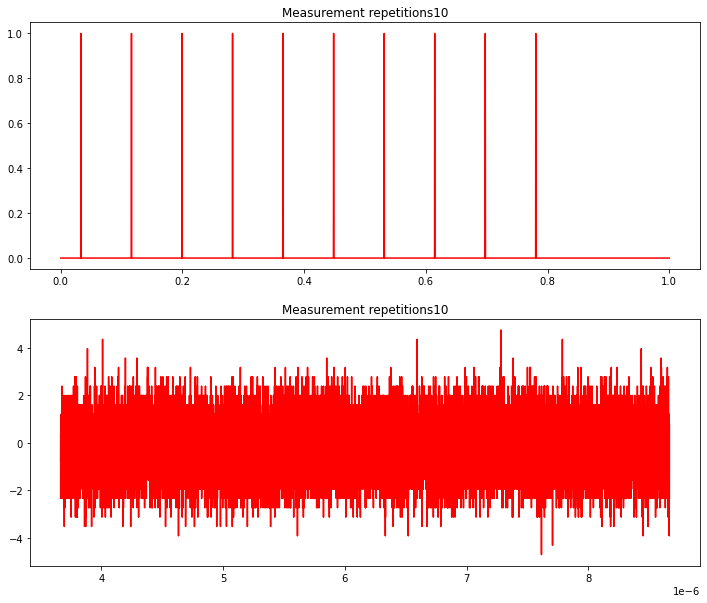

In [63]:
## Opening a data file
dfile = '2022-05-03__001_TEST.pkl.lz'
with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
    loaded_obj = pickle.load(f)
    print(loaded_obj.keys())
    print()
    print(loaded_obj['modulation'].keys())
    
    #### Plotting what you want
    fig, ax = plt.subplots(2,1,figsize = (12,10)) 
    #xax_mod = np.arange(0,wf.shape[0]*1/samplerate,1/samplerate)
    wf1 = loaded_obj['modulation']['wf1']
    ax[0].plot(np.linspace(0,1,wf1.shape[0]),wf1,color='red')
    #ax[0].set_xlim((1.5e-6,6.6e-6))
    ax[0].set_title('Measurement repetitions' + str(loaded_obj['repeats']))
    
    ax[1].plot(loaded_obj['meas_MEAN']['data_x'],loaded_obj['meas_MEAN']['data_y']*1000,color='red')
    ax[1].set_title('Measurement repetitions' + str(loaded_obj['repeats']))
    
    fig.savefig('figs\\test.png')